# Eksploracja danych zbioru "German credit data"
Julia Kaznowska, Piotr Wilczyński <br>
06/03/2022 <br>
Politechnika Warszawska, Wydział Matematyki i Nauk Informacyjnych, Wstęp do uczenia maszynowego

### Import niezbędnych bibliotek oraz zbioru danych

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
pd.options.mode.chained_assignment = None  # default='warn'

# zbior danych
df_full = pd.read_csv("german_credit_data_dataset.csv")

# wyświetlanie wizualizacji
%matplotlib inline

### Podział zbioru danych na dane budujące i do walidacji

Zbiór zawiera dane kredytowe i klasyfikuje klientów na "złych" i "dobrych" do udzielenia kredytu, gdzie klient "zły", gdy z udzieleniem mu kredytu wiąże się duże ryzyko (kolumna <i>customer_type</i>). Podzielimy zbiór na dane do budowania i walidacji w proporcjach 70/30. Aby zachować odpowiednie proporcje w kolumnie <i>customer_type</i> użyjemy losowania warstowowego.

In [3]:
random.seed(123)
np.random.seed(123)
df_build_temp = df_full.groupby('customer_type', group_keys=False).apply(lambda x: x.sample(frac=0.7))
df_build_temp.sort_index(inplace = True)
df_validate = df_full[~df_full.index.isin(df_build_temp.index)]
print(df_validate.index)
print(df_build_temp.index)
print(df_build_temp['customer_type'].value_counts()[2]/df_build_temp['customer_type'].value_counts()[1])
print(df_validate['customer_type'].value_counts()[2]/df_validate['customer_type'].value_counts()[1])

Int64Index([  1,   3,   4,   5,  12,  14,  17,  22,  24,  25,
            ...
            966, 972, 974, 979, 982, 991, 993, 995, 997, 998],
           dtype='int64', length=300)
Int64Index([  0,   2,   6,   7,   8,   9,  10,  11,  13,  15,
            ...
            985, 986, 987, 988, 989, 990, 992, 994, 996, 999],
           dtype='int64', length=700)
0.42857142857142855
0.42857142857142855


Wiersze wydają się być podzielone prawidłowo. Podzielimy dane do budowania na kolejne dwie części docelowo po to, aby testować modele. My ogarniczemy się narazie do eksploracji danych zatem drugą cześć zbioru będziemy używać do sprawdzania wniosków.

In [4]:
df_build = df_build_temp.groupby('customer_type', group_keys=False).apply(lambda x: x.sample(frac=0.7))
df_build.sort_index(inplace = True)
df_test = df_build_temp[~df_build_temp.index.isin(df_build.index)]
print(df_test.index)
print(df_build.index)
print(df_build['customer_type'].value_counts()[2]/df_build['customer_type'].value_counts()[1])
print(df_test['customer_type'].value_counts()[2]/df_test['customer_type'].value_counts()[1])

Int64Index([  6,  10,  13,  18,  20,  27,  31,  32,  33,  34,
            ...
            945, 953, 962, 965, 976, 978, 980, 984, 985, 988],
           dtype='int64', length=210)
Int64Index([  0,   2,   7,   8,   9,  11,  15,  16,  19,  21,
            ...
            981, 983, 986, 987, 989, 990, 992, 994, 996, 999],
           dtype='int64', length=490)
0.42857142857142855
0.42857142857142855


Przygotujmy nowe ramki do pracy.

In [5]:
df_build.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)
df_validate.reset_index(drop = True, inplace = True)

### Opis kolumn

Zobaczmy kolumny zbioru i jakiego są typu:

In [6]:
df_build.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   checking_account_status  490 non-null    object 
 1   duration                 490 non-null    int64  
 2   credit_history           490 non-null    object 
 3   purpose                  490 non-null    object 
 4   credit_amount            490 non-null    float64
 5   savings                  490 non-null    object 
 6   present_employment       490 non-null    object 
 7   installment_rate         490 non-null    float64
 8   personal                 490 non-null    object 
 9   other_debtors            490 non-null    object 
 10  present_residence        490 non-null    float64
 11  property                 490 non-null    object 
 12  age                      490 non-null    float64
 13  other_installment_plans  490 non-null    object 
 14  housing                  4

Wyjaśnienie kolumn:
1. checking_account_status - Status istniejącego rachunku bieżącego (A11: < 0 DM, A12: 0 <= x < 200 DM, A13 : >= 200 DM / cesja wynagrodzenia za co najmniej 1 rok, A14 : brak rachunku bieżącego)
2. duration - Okres kredytu w miesiącach
3. credit_history - Historia kredytowa (A30: brak zaciągniętych kredytów/wszystkie kredyty spłacone należycie, A31: wszystkie kredyty w tym banku spłacone należycie, A32: istniejące kredyty spłacane należycie do tej pory, A33: opóźnienie w spłacie w przeszłości, A34 : krytyczne konto/inne kredyty zaciągnięte (nie w tym banku))
4. purpose - Cel kredytu (A40: samochód (nowy), A41: samochód (używany), A42: meble/wyposażenie, A43: radio/telewizja, A44: sprzęt AGD, A45: naprawy, A46: edukacja, A47: urlop, A48: przekwalifikowanie, A49: biznes, A410: inne) 
5. credit_amount - Suma kredytu
6. savings - Oszczędności na rachunkach/obligacjach (A61: < 100 DM, A62: 100 <= x < 500 DM, A63: 500 <= x < 1000 DM, A64: >= 1000 DM, A65: nieznane/ brak konta oszczędnościowego 
7. present_employment - Długość obecnego zatrudnienia. A71: bezrobotni, A72: < 1 rok, A73: 1 <= x < 4 lat, A74: 4 <= x < 7 lat, A75: .. >= 7 lat 
8. installment_rate - Stawka raty w procentach dochodu rozporządzalnego
9. personal - Osobisty stan cywilny i płeć (A91: mężczyzna rozwiedziony/w separacji, A92: kobieta rozwiedziona/w separacji/mężatka, A93: mężczyzna kawaler, A94: mężczyzna żonaty/wdowiec, A95: kobieta panna)
10. other_debtors - Inni dłużnicy (A101: brak, A102: współwnioskodawca, A103: poręczyciel)
11. present_residence - Obecne miejsce zamieszkania od
12. property - Nieruchomości (A121: nieruchomość, A122: jeśli nie A121 : umowa oszczędnościowa/ubezpieczenie na życie, A123: jeśli nie A121/A122 : samochód lub inny, nie w atrybucie 6, A124 : nieznane / brak nieruchomości) 
13. age - Wiek w latach
14. other_installment_plans - Inne plany ratalne (A141: banki, A142: sklepy, A143: brak)
15. housing - Zamieszkanie (A151: wynajem, A152: właściciel, A153: za darmo)
16. existing_credits - Liczba kredytów w tym banku
17. job - Zatrudnienie (A171: bezrobotni/niewykwalifikowani - bez stałego miejsca zamieszkania, A172: niewykwalifikowani - stałe miejsce zamieszkania, A173: wykwalifikowany pracownik/urzędnik, A174: stanowisko kierownicze/samozatrudnienie, wysoko wykwalifikowany pracownik/funkcjonariusz)
18. dependents - Liczba osób, za które klient jest odpowiedzialny finansowo
19. telephone - (A191: brak, A192: tak, zarejestrowany na nazwisko klienta)
20. foreign_worker - Pracownik zagraniczny (A201: yes, A202: no )
21. customer_type - Rodzaj klienta (1 - dobry (niskiego ryzka), 2 - zły (wysokiego ryzyka))

Zobaczmy pierwsze rekordy ramki

In [7]:
df_build.head()

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,customer_type
0,A11,6,A34,A43,1169.0,A65,A75,4.0,A93,A101,...,A121,67.0,A143,A152,2.0,A173,1,A192,A201,1
1,A14,12,A34,A46,2096.0,A61,A74,2.0,A93,A101,...,A121,49.0,A143,A152,1.0,A172,2,A191,A201,1
2,A12,36,A32,A41,6948.0,A61,A73,2.0,A93,A101,...,A123,35.0,A143,A151,1.0,A174,1,A192,A201,1
3,A14,12,A32,A43,3059.0,A64,A74,2.0,A91,A101,...,A121,61.0,A143,A152,1.0,A172,1,A191,A201,1
4,A12,30,A34,A40,5234.0,A61,A71,4.0,A94,A101,...,A123,28.0,A143,A152,2.0,A174,1,A191,A201,2


Podzielmy kolumny na numeryczne i kategoryczne

In [8]:
df_build.apply(lambda x: len(x.unique()))

checking_account_status      4
duration                    27
credit_history               5
purpose                     10
credit_amount              470
savings                      5
present_employment           5
installment_rate             4
personal                     4
other_debtors                3
present_residence            4
property                     4
age                         49
other_installment_plans      3
housing                      3
existing_credits             4
job                          4
dependents                   2
telephone                    2
foreign_worker               2
customer_type                2
dtype: int64

Zatem zmienne <i>duration</i>, <i>credit_amount</i>, <i>age</i> są numeryczne, resztę można uznać za kategoryczne. 

In [9]:
numeric_columns = np.array(["duration", "credit_amount", "age"])
nominal_columns = df_build.columns.values
nominal_columns = np.delete(nominal_columns, [1, 4, 12])

oraz podstawowe cechy zmiennych numerycznych.

In [10]:
df_build[numeric_columns].describe()

,duration,credit_amount,age
count,490.000000,490.00000,490.000000
mean,20.734694,3293.70000,35.653061
std,12.225347,2867.67057,11.102517
min,4.000000,250.00000,20.000000
25%,12.000000,1361.75000,27.000000
50%,18.000000,2363.00000,33.000000
75%,24.000000,4033.00000,42.000000
max,60.000000,18424.00000,75.000000


### Braki danych

Na stronie, z której pochodzi zbiór danych jest informacja, że numeryczne braki danych są oznaczone "-100000", a nominalne "?".

In [11]:
"?" in df_build.apply(lambda x: x.value_counts()).index

False

In [12]:
"-100000" in df_build.apply(lambda x: x.value_counts()).index

False

In [12]:
df_build.apply(lambda x: x.isna().sum(), axis=0)

checking_account_status    0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
present_employment         0
installment_rate           0
personal                   0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
dependents                 0
telephone                  0
foreign_worker             0
customer_type              0
dtype: int64

Wydaje się, że w ramce nie ma żadnych nulli.

### Wstępna analiza danych

Do wstępnej analizy danych będziemy używać raportu pakietu Pandas-profiling.

In [6]:
profile = ProfileReport(df_build, title = "German credit data - Exploratory Data Analysis")
profile.to_notebook_iframe()

### Jednowymiarowa analiza zmiennych

#### Zmienne numeryczne

C:\Users\farbo\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


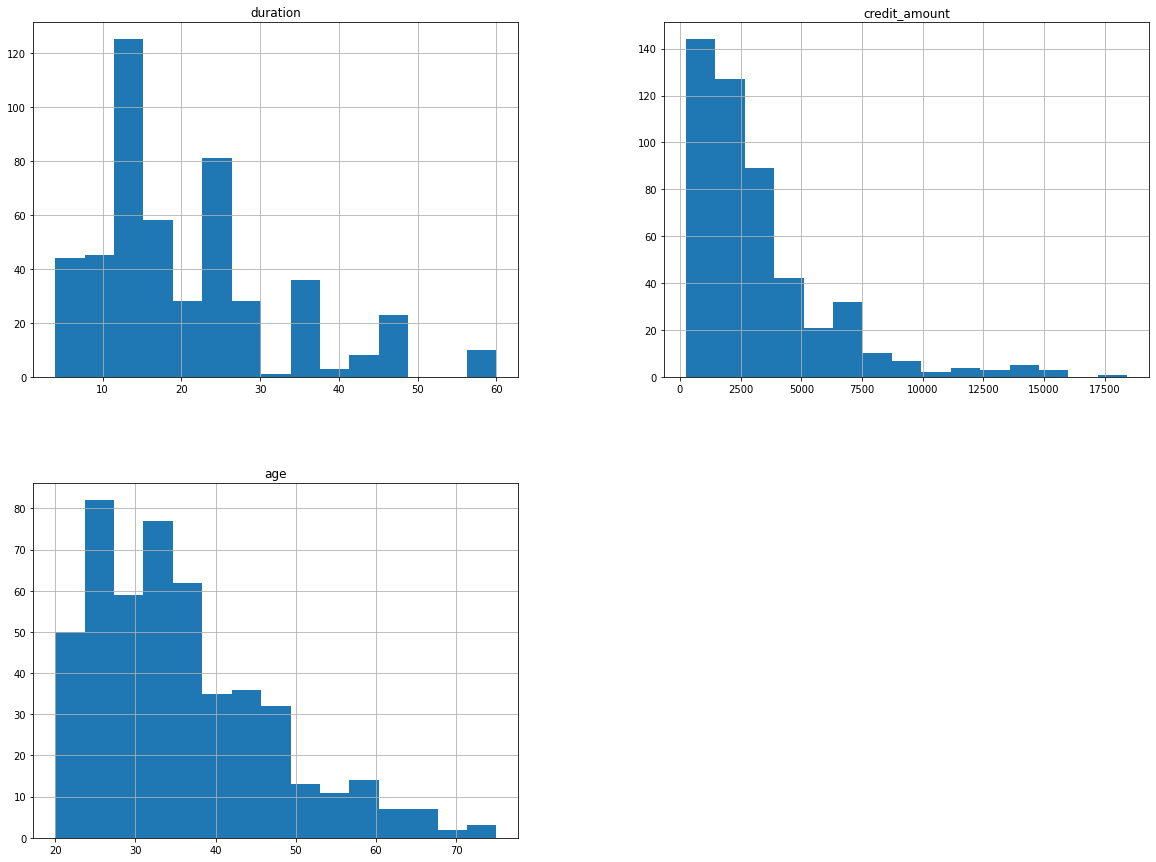

In [13]:
df_build.hist(column = numeric_columns, figsize = [20, 15], bins = 15)
plt.show()

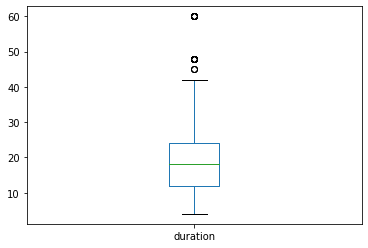

In [14]:
df_build["duration"].plot(kind = "box")
plt.show()

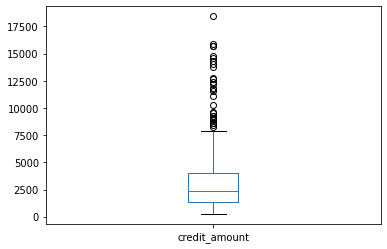

In [15]:
df_build["credit_amount"].plot(kind = "box")
plt.show()

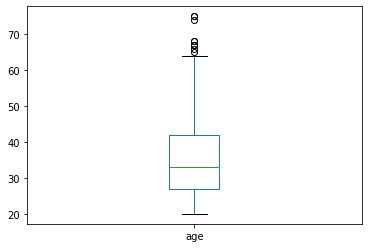

In [16]:
df_build["age"].plot(kind = "box")
plt.show()

#### Zmienne kategoryczne

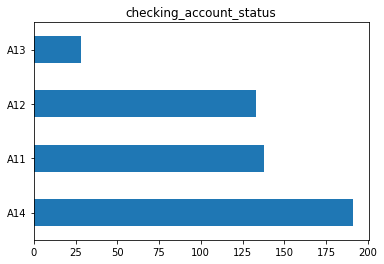

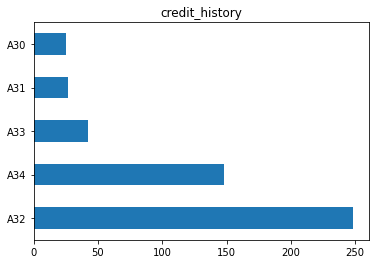

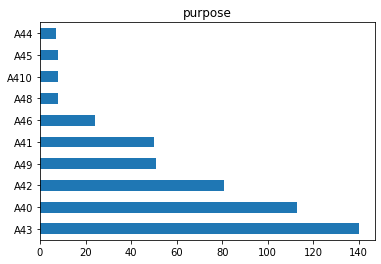

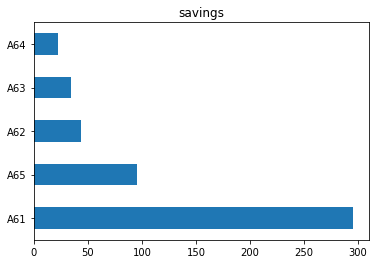

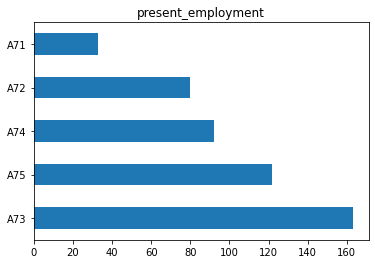

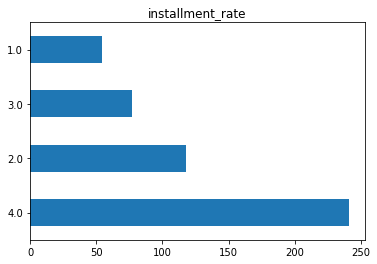

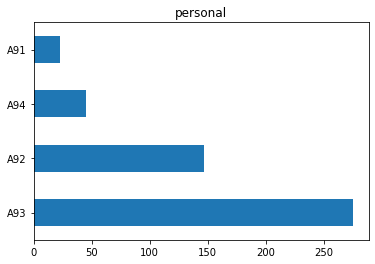

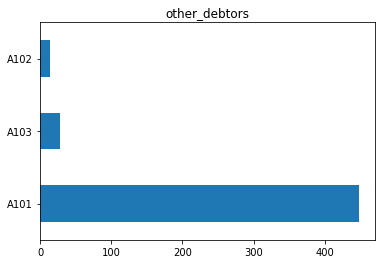

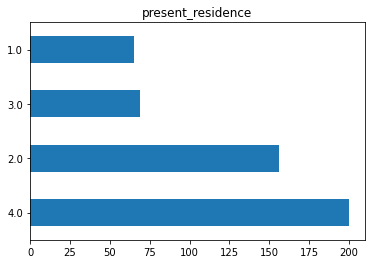

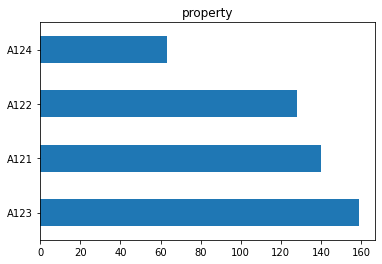

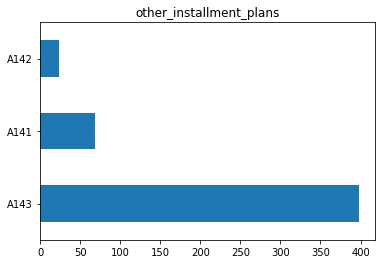

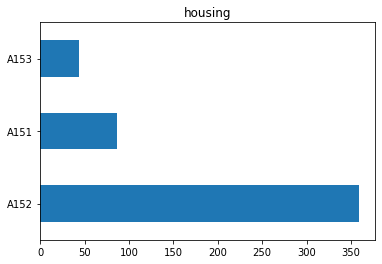

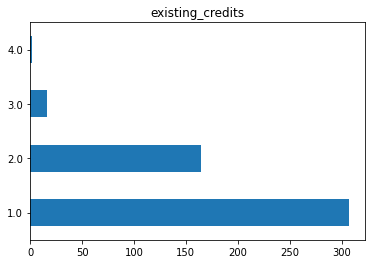

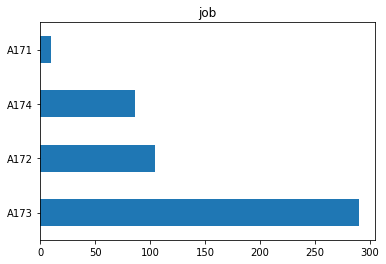

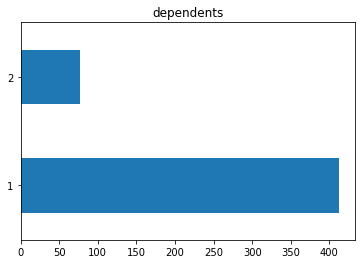

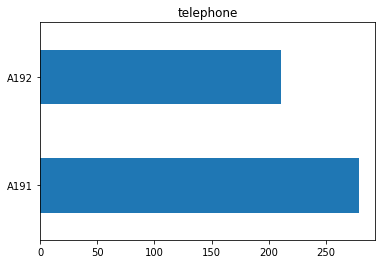

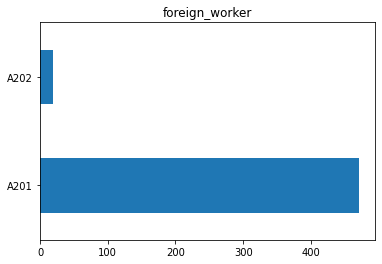

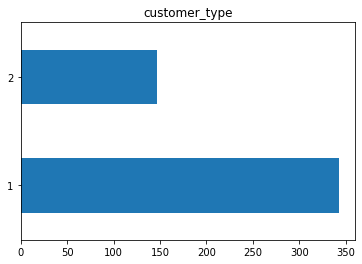

In [17]:
for col in nominal_columns:
    df_build[col].value_counts().plot(kind = "barh")
    plt.title(col)
    plt.show()

Z analizy zmiennych kategorycznych wynika, że:
- najwięcej klientów nie posiada rachunku bieżącego
- najwięcej klientów ma zaciągnięty kredyt i spłaca go w czasie
- najwięcej kredytów jest branych na zakup telewizora bądź radia; następnym najczęstszym zakupem jest nowe auto
- najwięcej klientów posiada oszczędności < 100DM
- najwięcej klientów jest zatrudnionych od 1 do 4 lat
- najwięcej klientów posiada stawkę raty w wysokości 4% dochodu rozporządzalnego
- najwięcej klientów jest kawalerami
- większość klientów nie jest poręczycielem ani współwnioskodawcą
- zdecydowana większość klientów posiada nieruchomości
- większość klientów nie posiada innych planów ratalnych
- większość klientów jest właścicielem swojego miejsca zamieszkania
- większość klientów posiada jeden kredyt w tym banku
- większość klientów jest wykwalifikowanym pracownikiem bądź urzędnikiem
- zdecydowana większość klientów jest odpowiedzialna finansowo za jedną osobę
- trochę więcej klientów nie posiada telefonu zarejestrowanego na swoje nazwisko
- zdecydowana większość klientów jest pracownikiem zagranicznym
- więcej klientów jest niskiego ryzyka

### Wielowymiarowa analiza zmiennych

W wielowymiarowej analizie danych skupimy się głównie na powiązaniu poszczególnych zmiennych z typem klienta. 

#### Zmienne kategoryczne

In [ ]:
# usunięcie kolumny customer_type
nominal_columns2 = np.delete(nominal_columns, [17])

W poniższych wykresach przedstawione zostały rozkłady poszczególnych zmiennych w zależności od typu klienta. Dla dobrych klientów wykres jest niebieski, dla złych - pomarańczowy.

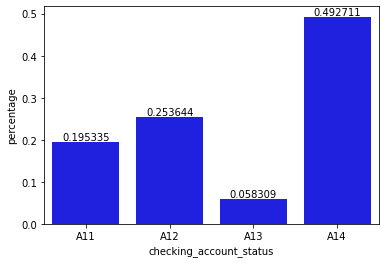

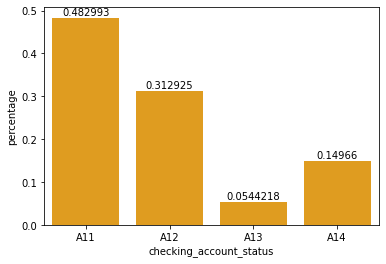

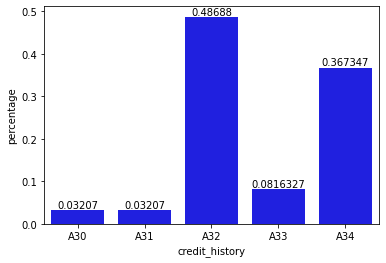

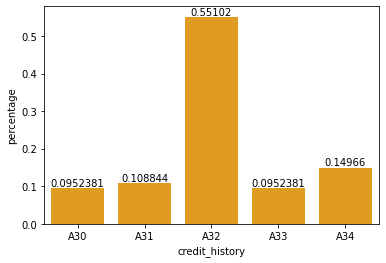

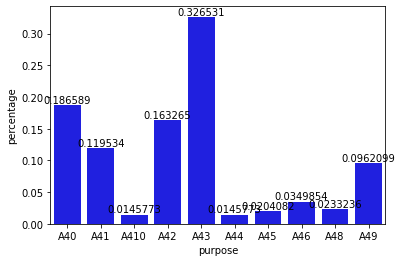

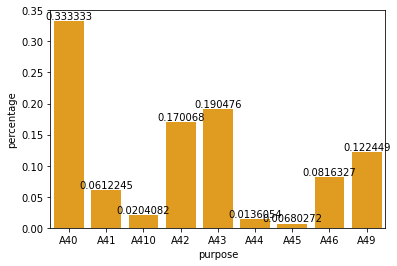

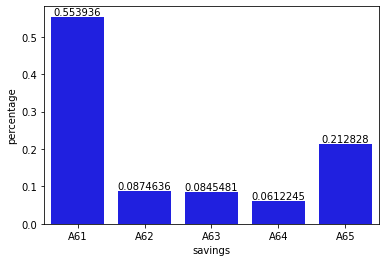

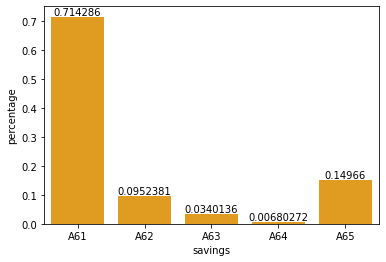

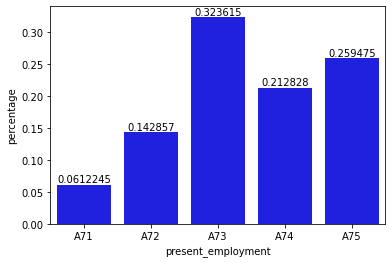

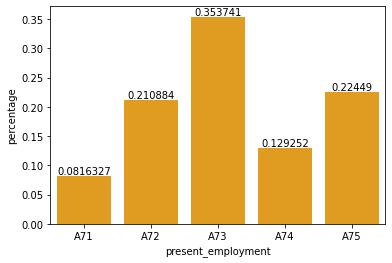

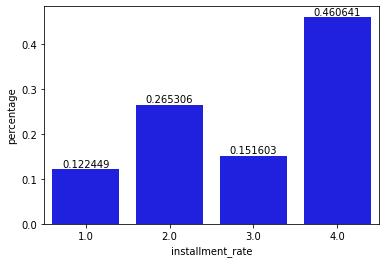

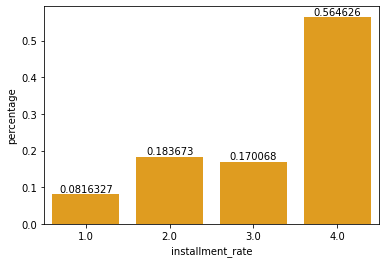

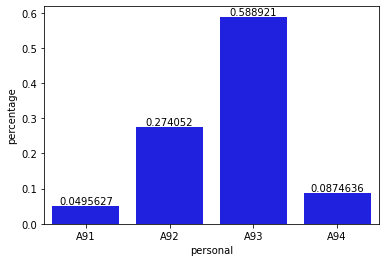

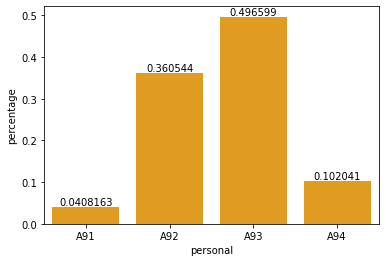

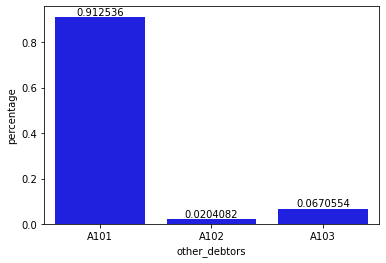

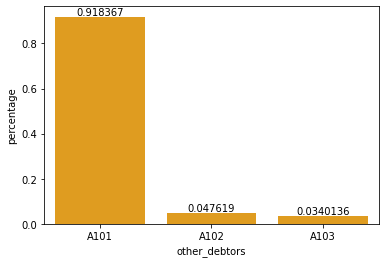

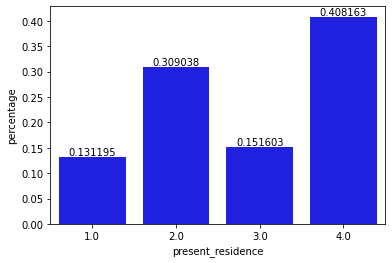

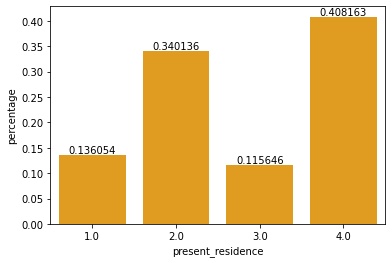

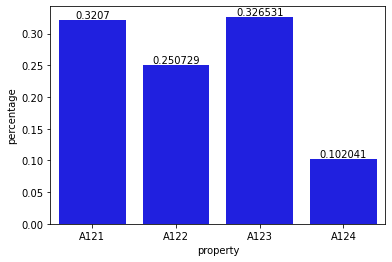

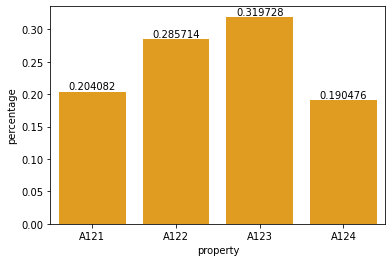

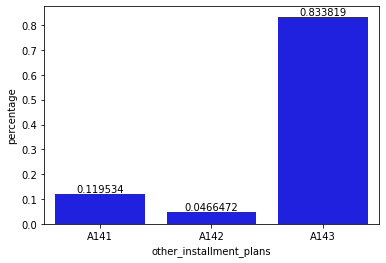

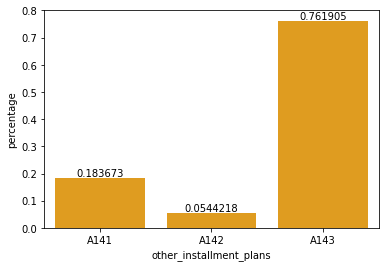

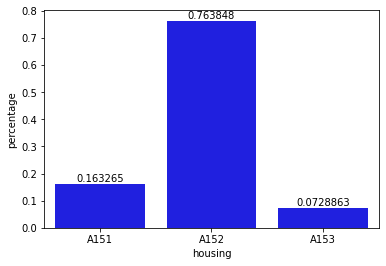

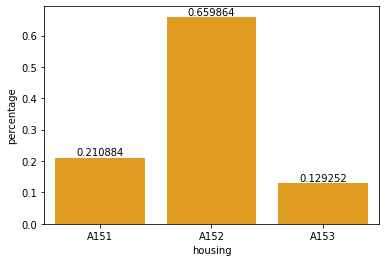

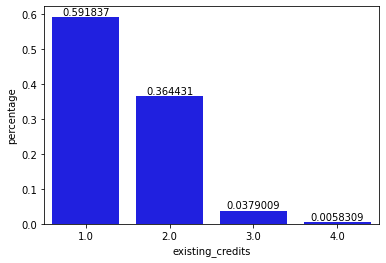

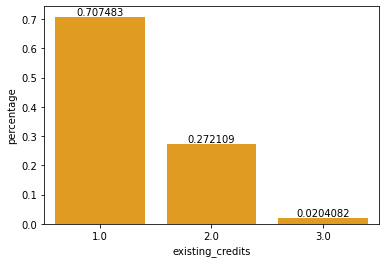

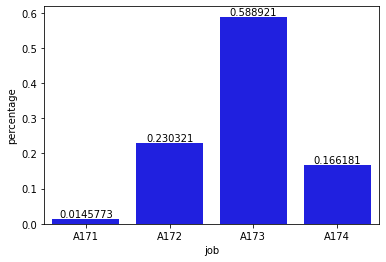

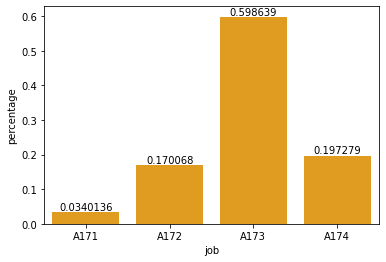

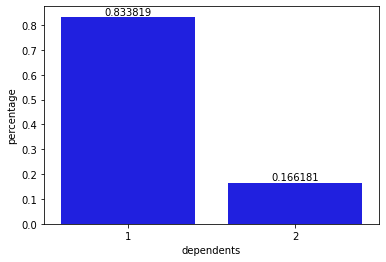

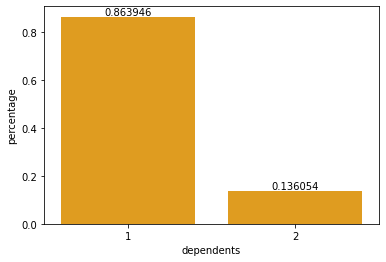

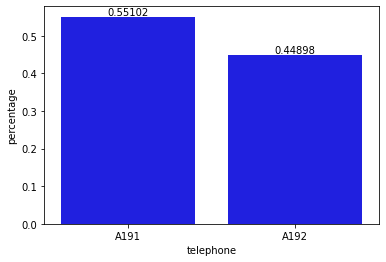

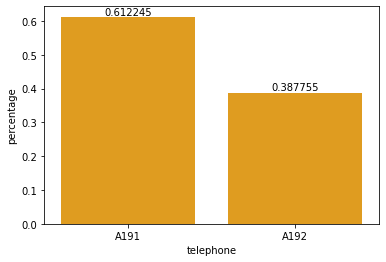

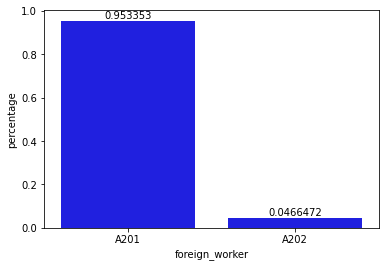

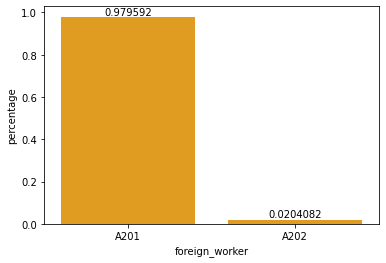

In [52]:
for col in nominal_columns2:
    dfprep = df_build.groupby(by = ['customer_type', col]).size().reset_index(name='count')
    
    dfprep1 = dfprep.loc[dfprep['customer_type'] == 1]
    sum1 = sum(dfprep1['count'])
    dfprep1["percentage"] = dfprep1['count']/sum1
    
    dfprep2 = dfprep.loc[dfprep['customer_type'] == 2]
    sum2 = sum(dfprep2['count'])
    dfprep2["percentage"] = dfprep2['count']/sum2
    
    plt.figure()
    ax = sns.barplot(x=col, y="percentage", data=dfprep1, color = 'blue')
    ax.bar_label(ax.containers[0])
    plt.show()
    
    plt.figure()
    ax = sns.barplot(x=col, y="percentage", data=dfprep2, color = 'orange')
    ax.bar_label(ax.containers[0])
    plt.show()

In [54]:
#for col in nominal_columns2:
#    dfprep = df_build.groupby(by = ['customer_type', col]).size().reset_index(name='count')
#
#    plt.figure()
#    ax = sns.barplot(x=col, y="count", hue="customer_type", data=dfprep)

Wielowymiarowa analiza danych kategorycznych pozwala dojść do następujących wniosków:
- klienci bez rachunku bieżącego są z bardzo dużym prawdopodobieństwem dobrymi klientami
- udzielanie kredytów klientom z rachunkiem bieżącym <0 DM może wiązać się z podwyższonym ryzykiem
- klienci z kontem krytycznym lub kredytem zaciągniętym w innym banku przejawiają się niskim ryzykiem
- udzielenie pożyczki na telewizor bądź radio wiąże się z niższym ryzykiem, natomiast na nowy samochód - z większym
- klienci z mniejszymi oszczędnościami rzadziej spłacają kredyty w czasie
- kobiety niebędące pannami są przeważnie złymi klientami
- klienci posiadający nieruchomości prawdopodobnie będą spłacać kredyty w czasie

#### Zmienne numeryczne

##### Poszukiwanie korelacji

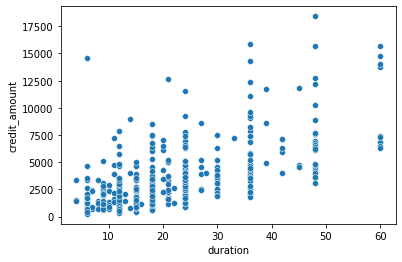

In [56]:
#plt.figure()
#sns.scatterplot(data=df_build, x="duration", y="credit_amount")
#plt.show()

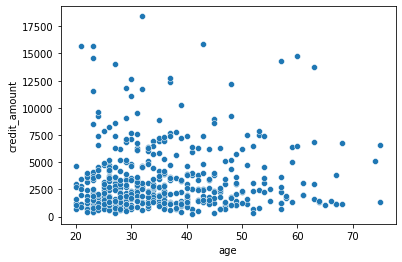

In [39]:
#plt.figure()
#sns.scatterplot(data=df_build, x="age", y="credit_amount")
#plt.show()

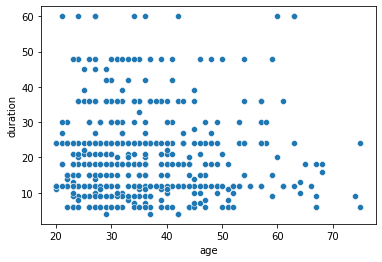

In [40]:
#plt.figure()
#sns.scatterplot(data=df_build, x="age", y="duration")
#plt.show()

##### Połączenie z typem klienta

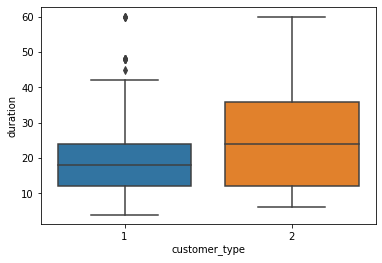

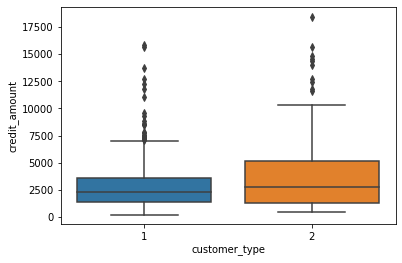

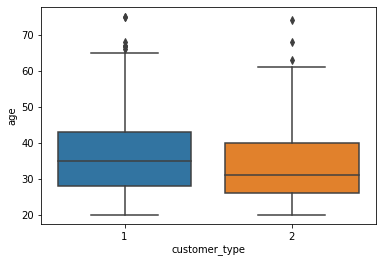

In [44]:
for col in numeric_columns:
    plt.figure()
    ax = sns.boxplot(x="customer_type", y =col, data=df_build)
    plt.show()

Z analizy wielowymiarowej zmiennych numerycznych wynika, że im większa kwota kredytu oraz dłuższy okres kredytu, tym mniejsza szansa na spłacenie go w czasie.

### Sprawdzenie wniosków zestawem testowym

Na początku sprawdźmy podstawowe informacje o zbiorze danych. Zacznijmy od podziału na zmienne kategoryczne i numeryczne.

In [57]:
df_test.apply(lambda x: len(x.unique()))

checking_account_status      4
duration                    22
credit_history               5
purpose                     10
credit_amount              208
savings                      5
present_employment           5
installment_rate             4
personal                     4
other_debtors                3
present_residence            4
property                     4
age                         45
other_installment_plans      3
housing                      3
existing_credits             4
job                          4
dependents                   2
telephone                    2
foreign_worker               2
customer_type                2
dtype: int64

Tak jak w poprzedniej części zbioru danych zauważamy, że 3 kolumny (duration, credit_amount oraz age) można uznać za numeryczne, resztę zaś za kategoryczne.

Sprawdźmy teraz, czy w testowym zbiorze danych występują jakieś braki wartości. 

In [62]:
"?" in df_test.apply(lambda x: x.value_counts()).index

False

In [63]:
"-100000" in df_test.apply(lambda x: x.value_counts()).index

False

In [64]:
df_test.apply(lambda x: x.isna().sum(), axis=0)

checking_account_status    0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
present_employment         0
installment_rate           0
personal                   0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
dependents                 0
telephone                  0
foreign_worker             0
customer_type              0
dtype: int64

W zbiorze testowym również nie zauważamy braków danych.

### Analiza jednowymiarowa

**tu zmienne numeryczne**

#### Zmienne kategoryczne

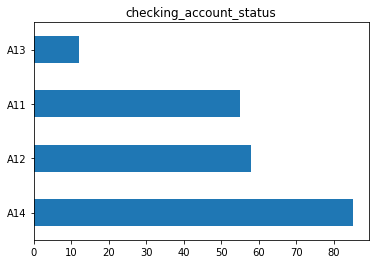

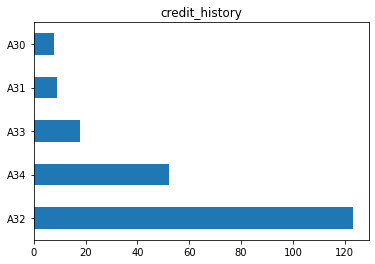

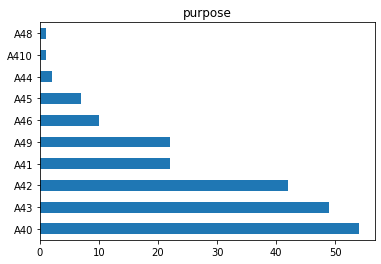

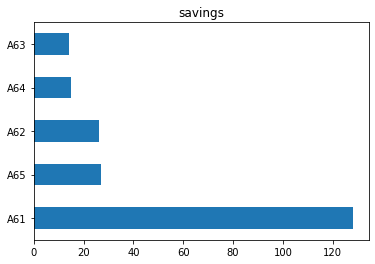

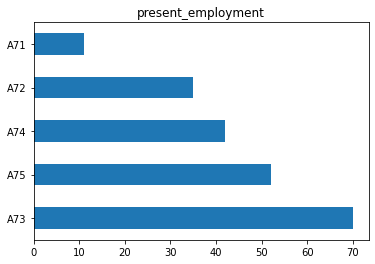

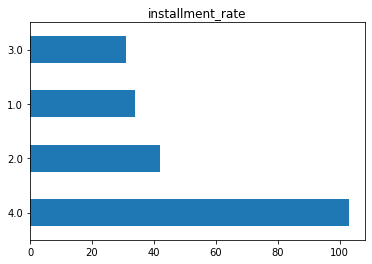

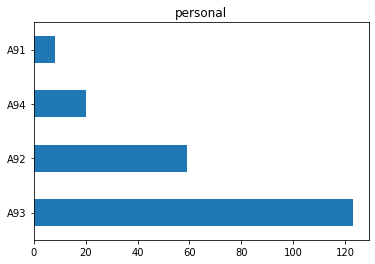

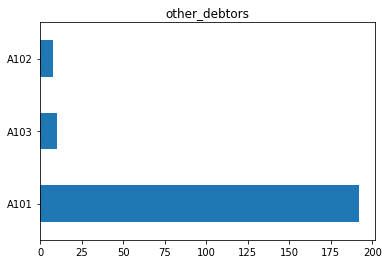

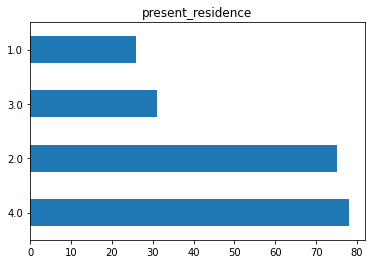

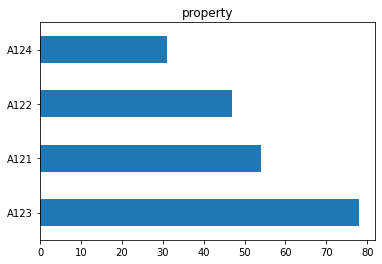

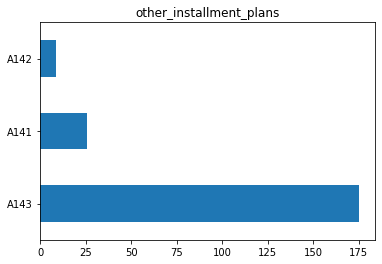

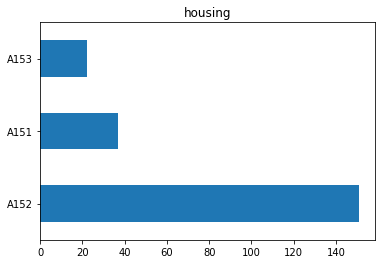

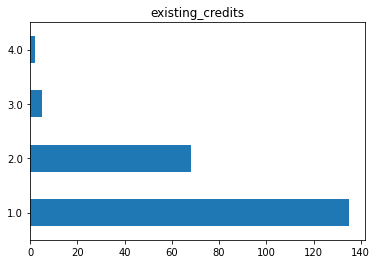

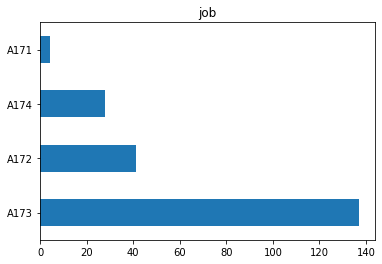

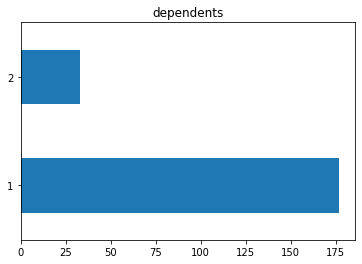

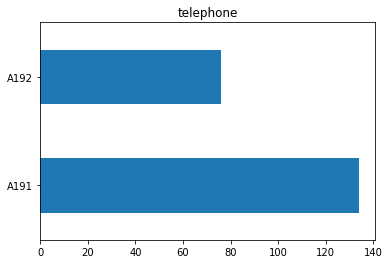

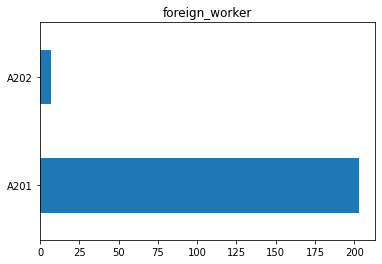

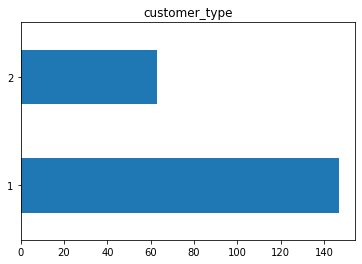

In [65]:
for col in nominal_columns:
    df_test[col].value_counts().plot(kind = "barh")
    plt.title(col)
    plt.show()

Analiza jednowymiarowa zmiennych kategorycznych przynosi podobne wnioski. Można zauważyć jednak drobne różnice:
- najwięcej klientów bierze kredyt na zakup nowego auta; tuż za tym wydatkiem jest zakup telewizora bądź radia. Dwie pierwsze pozycje zatem się zgadzają, zmieniona jest ich kolejność, lecz różnica wynosi jedynie kilka osób
- najwięcej klientów posiada auto jako swoją własność, bez posiadania nieruchomości

### Wielowymiarowa analiza danych

#### Zmienne kategoryczne

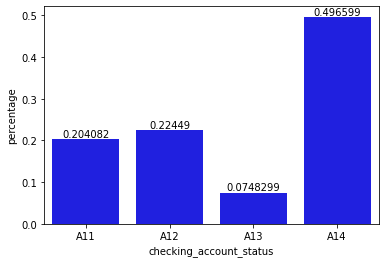

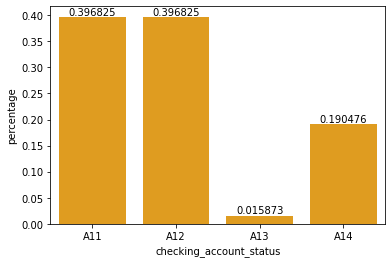

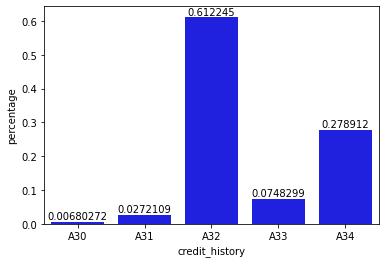

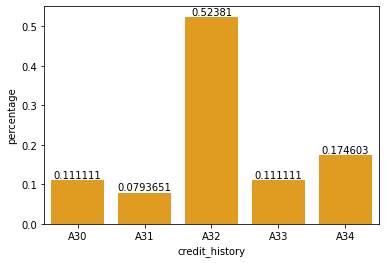

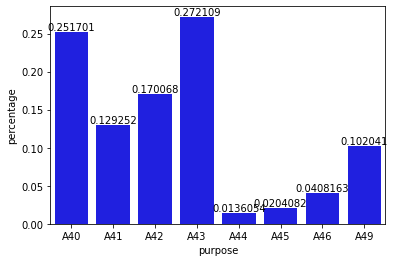

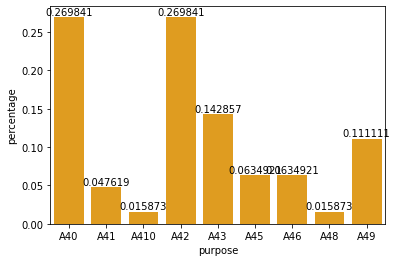

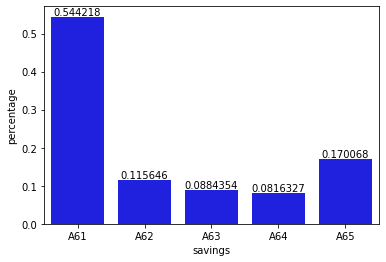

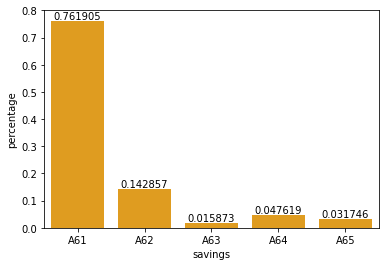

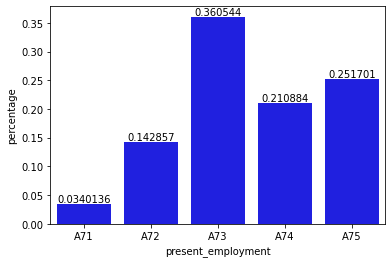

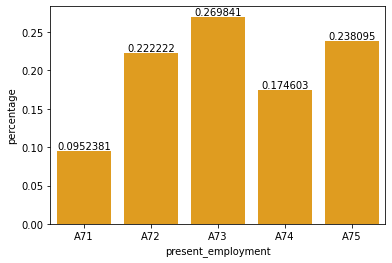

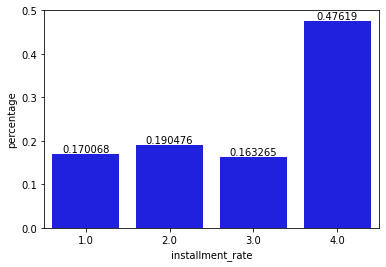

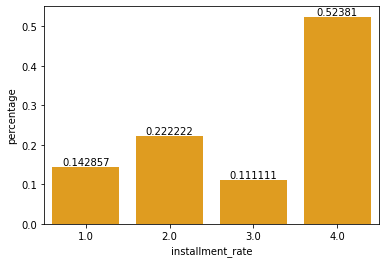

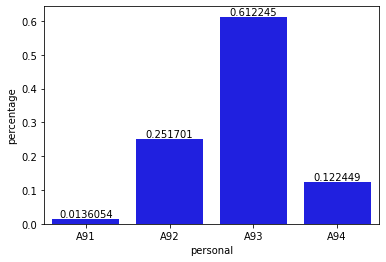

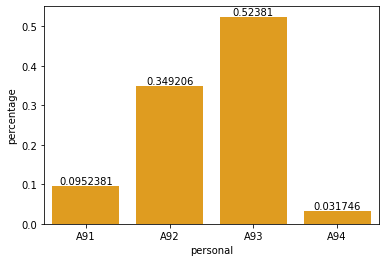

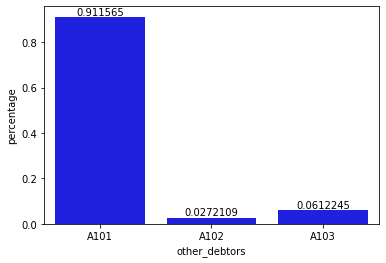

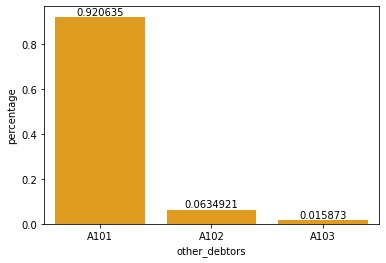

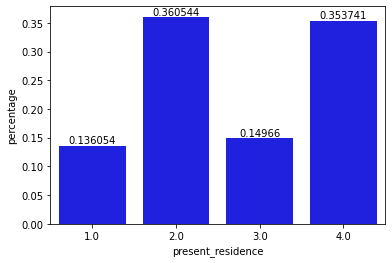

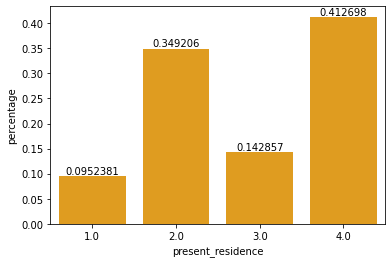

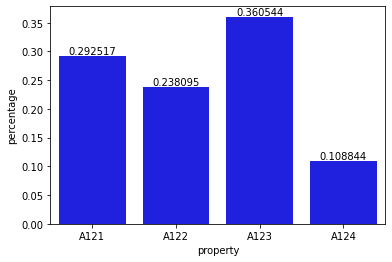

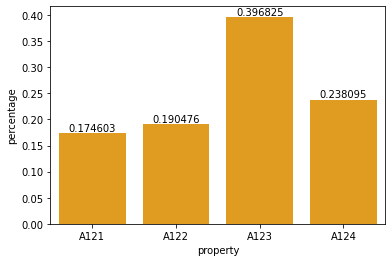

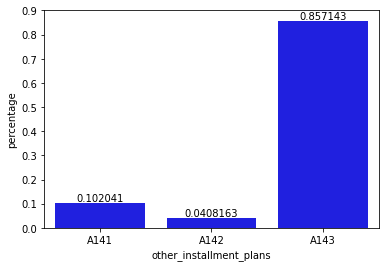

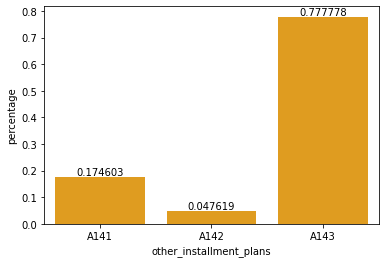

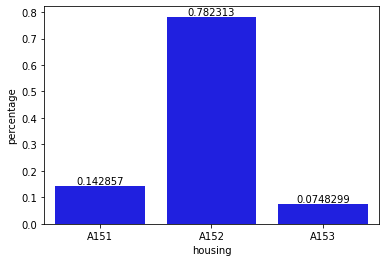

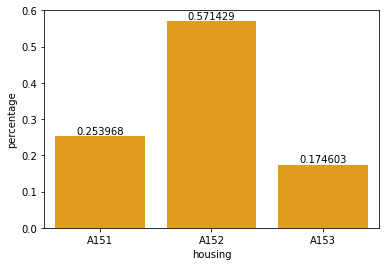

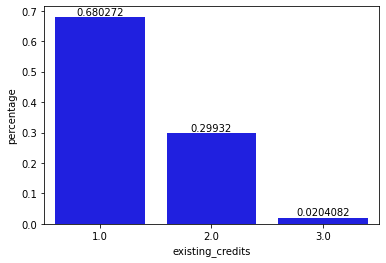

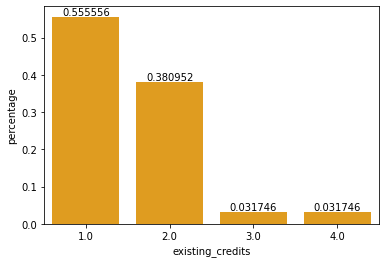

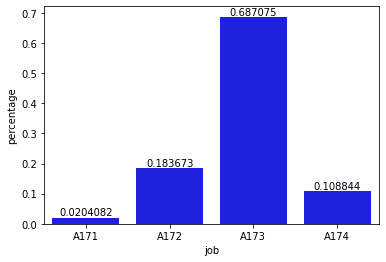

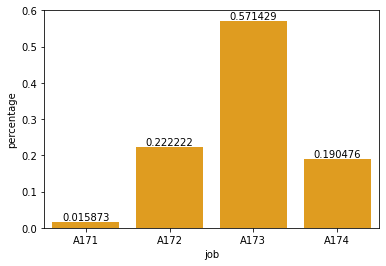

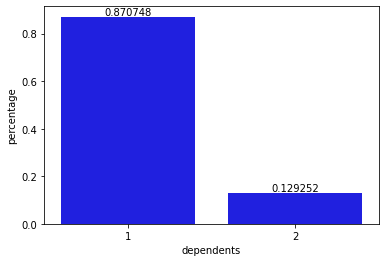

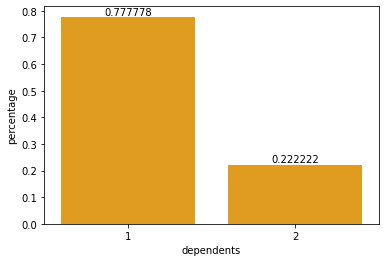

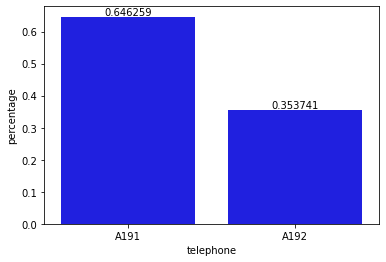

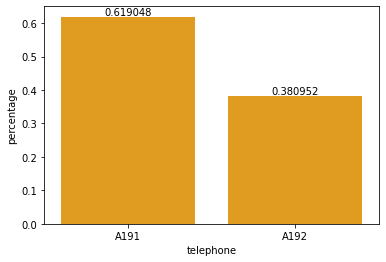

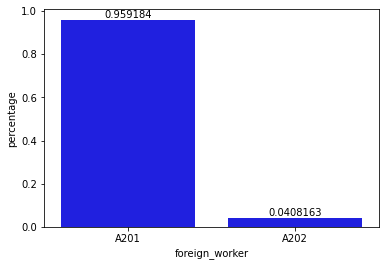

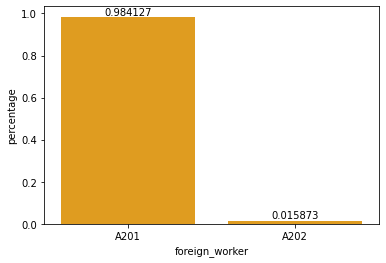

In [67]:
for col in nominal_columns2:
    dfprep = df_test.groupby(by = ['customer_type', col]).size().reset_index(name='count')
    
    dfprep1 = dfprep.loc[dfprep['customer_type'] == 1]
    sum1 = sum(dfprep1['count'])
    dfprep1["percentage"] = dfprep1['count']/sum1
    
    dfprep2 = dfprep.loc[dfprep['customer_type'] == 2]
    sum2 = sum(dfprep2['count'])
    dfprep2["percentage"] = dfprep2['count']/sum2
    
    plt.figure()
    ax = sns.barplot(x=col, y="percentage", data=dfprep1, color = 'blue')
    ax.bar_label(ax.containers[0])
    plt.show()
    
    plt.figure()
    ax = sns.barplot(x=col, y="percentage", data=dfprep2, color = 'orange')
    ax.bar_label(ax.containers[0])
    plt.show()

Na podstawie powyższych rozkładów również można wyciągnąć bardzo podobne wnioski, z kolejnymi, drobnymi poprawkami:
- mniej bezpieczne jest udzielanie kredytów nie tylko klientom z rachunkiem bieżącym <0DM, lecz również tym z rachunkiem bieżącym <200DM
- udzielenie pożyczki na używany samochód wiąże się z mniejszym ryzykiem; na cele inne - z wysokim
- klienci wynajmujący mieszkanie bądź mieszkający za darmo prawdopodobnie będą złymi klientami

### Zmienne numeryczne

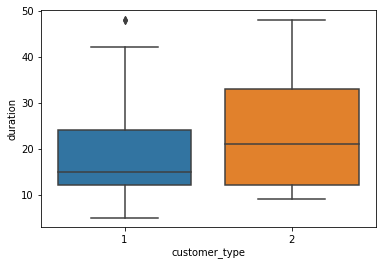

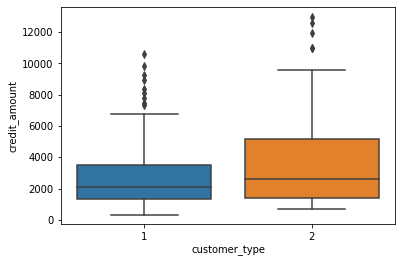

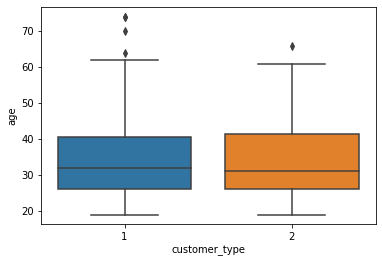

In [69]:
for col in numeric_columns:
    plt.figure()
    ax = sns.boxplot(x="customer_type", y =col, data=df_test)
    plt.show()

Na podstawie wykresów ze zmiennymi numerycznymi można wyciągnąć identyczne wnioski jak w analizie początkowego zbioru.

## Wady pandas-profiling

Mimo swojej ogromnej użyteczności, to narzędzie do automatycznej analizy danych ma swoje niedoskonałości. Jeśli zmienna "brak danych" opisana by była jako dowolna wartość (np. 0 czy "A1002"), to nie dostalibyśmy tej informacji bezpośrednio - dopiero analiza wyników przez człowieka mogłaby to wykryć. **Kolejnym minusem jest możliwość uznania zmiennych kategorycznych za numeryczne (jeśli kategorii byłoby wiele i byłyby one opisane liczbami).** Nie uświadczymy również żadnych innych wykresów poza histogramami, wykresami kolumnowymi i kołowymi (jak np. boxplot), które często pokazują więcej niż powyższe. Automatyczna analiza nie pokaże również zależności między poszukiwaną zmienną a innymi zmiennymi kategorycznymi, co często stanowi sporą część analizy wielowymiarowej zbioru danych. Warto też wspomnieć, że dla bardzo dużych zbiorów danych takie narzędzia są powolne.